In [1]:
import windscangeo
import datetime
from torch import nn


%reload_ext autoreload
%autoreload 2

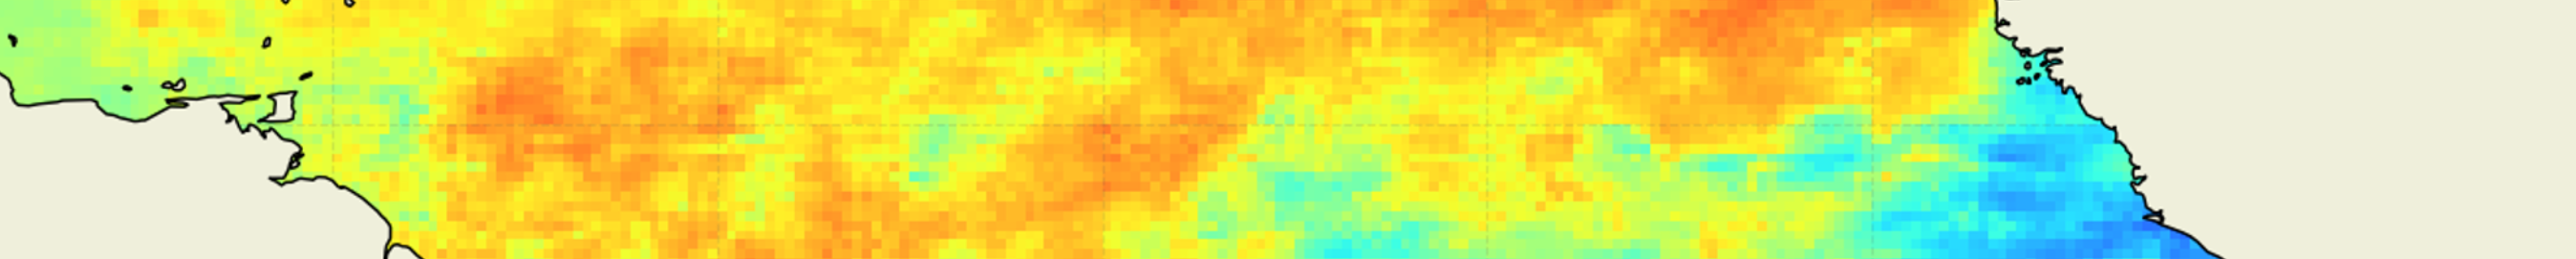

#  Tutorial WindScanGEO 
This notebook demonstrates how to use the WindScanGEO package to estimate wind speeds from GOES geostationary satellite imagery. The workflow consists of the following key steps:

1. Data Extraction – Collocate satellite orbits and extract all relevant input data (images and wind speed labels).

2. Model Training – Train a deep learning model on the extracted dataset.

3. Inference – Apply the trained model to perform wind speed prediction on a target GOES image.



---

## 1. 🔁 Orbit Matching with Scatterometer Data

The orbit matching process begins with a NetCDF file containing wind speed measurements from a polar-orbiting scatterometer satellite. This file must be manually downloaded from the **Copernicus Marine Service**:

[WIND_GLO_PHY_L3_NRT_012_002](https://data.marine.copernicus.eu/product/WIND_GLO_PHY_L3_NRT_012_002/description)

Alternatively, an **API is available** for automating the download of scatterometer data. Refer to the **WindScanGEO User Guide** for detailed instructions on how to access and retrieve these files.

---

### **Function: `extract_matching_orbits()`**

This function performs the core matching between polar scatterometer data and GOES geostationary imagery.

### **Inputs:**
- **Scatterometer folder**: Directory containing one or more `.nc` files.
  - If multiple files are provided, ensure they share the same grid and lat/lon extent.
- **GOES product**: The S3 path of the GOES product (e.g., `noaa-goes16/ABI-L2-CMIPF`).
- **GOES channel**: The spectral channel to extract (e.g., `'C01'`, `'C05'`, etc.).
- **Image size**: Size (in pixels) of the extracted image patches. Default is `128x128`.

### **Outputs :**

- **images** : array of shape (n,1,height,width) containing the GOES satelite images. These can be stacked later for multi-channel training
- **numerical_data** : Target wind speed + lat/lon/time metadata
- **saved_file_path** file path where a `.npz` file is saved with all the processed data.

#### Description:
The function will:
- Match scatterometer measurements with the corresponding GOES image based on time and location.
- Extract image patches at the specified resolution for matching locations.
- Return all lat/lon positions where a valid match exists.

As part of the process, a folder `./satellite_indices/` will be created with an array that maps the GOES satellite grid with the scatterometer grid. If this is the first time the package is being run in the current directory, the function will create this file and directory during the run.

---

### Supported GOES Products

This framework has been tested with:

- `noaa-goes16/ABI-L2-CMIPF` — Cloud and Moisture Imagery (Level 2)
- `noaa-goes16/ABI-L1b-RadF` — Radiances (Level 1b Full Disk)

These are the AWS buckets in which the products are stored. Other products than these may also be compatible but have not be tested. Use at your own risk. For a complete list, visit:

[NOAA GOES Data Registry (AWS)](https://registry.opendata.aws/noaa-goes/)

---

### Default Image Size

The default patch size is **128x128 pixels**, chosen to balance spatial detail and file size. Users can specify custom sizes depending on their application needs.


In [4]:
images, numerical_data, saved_file_path = windscangeo.extract_matching_orbits(scatterometer_data_path= "../Copernicus_Scatterometer/",
                                    date= '2022-01-01',
                                    lat_range= [-90, 90],
                                    lon_range=[-180, 180],
                                    goes_aws_url_folder= "noaa-goes16/ABI-L2-CMIPF", #or "noaa-goes16/ABI-L1b-RadF" (rest not yet optimized, at your own risk !) https://registry.opendata.aws/noaa-goes/
                                    goes_channel= 'C06',
                                    goes_image_size = 128,
                                    verbose= True,
                                    save = True,
)

START : Extracting matching orbits for date: 2022-01-01
INFO : lat_range: [-90, 90]
INFO : lon_range: [-180, 180]
INFO : goes_channel: C06 at url: noaa-goes16/ABI-L2-CMIPF
INFO : Extracting scatterometer data from folder :  ../Copernicus_Scatterometer/
___
ORBIT : MetOp-C ASCAT overpass time : ['01:22', '21:33', '23:15']
ORBIT : HY-2C HSCAT overpass time : ['12:24', '14:09', '15:54', '17:44', '19:31']
ORBIT : MetOp-B ASCAT overpass time : ['00:24', '02:13', '20:41', '22:21']
ORBIT : HY-2B HSCAT overpass time : ['18:00', '19:44', '21:32', '23:21']
ORBIT : MetOp-C ASCAT overpass time : ['08:56', '10:32', '12:13', '13:55']
ORBIT : HY-2B HSCAT overpass time : ['05:00', '11:51']
ORBIT : HY-2C HSCAT overpass time : ['01:11', '02:49', '04:33', '06:18']
ORBIT : MetOp-B ASCAT overpass time : ['08:09', '09:44', '11:20', '13:01', '14:43']
___
INFO : Total number of scatterometer data points: 113296
INFO : Total number of scatterometer data points at daylight : 56677


INFO : Retrieving and processing GOES data:   0%|          | 0/24 [00:00<?, ?it/s]

INFO : Satellite index file not found, creating new index file. This might take a while.


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:131: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)


INFO : Latitude and longitude calculated
INFO : Calculating indices


INFO : Retrieving and processing GOES data: 100%|██████████| 24/24 [06:48<00:00, 17.02s/it]


INFO : Extracted 56677 images from 24 GOES files.
INFO : Filtered invalid images. Removed 1601 entries.
INFO : Filled nans
END : Extracted : 55076  training pairs
INFO : Saving preloaded data to file :  ./saved_files/file_preloaded_2022-01-01_C06.npz


## 2. Model Training

We can directly train a model from the saved data extracted in the previous step. The WindScanGEO includes a function that trains and test the model with pre-included common architectures. 



### **Function: `train_test_model()`**

Trains a deep learning model (e.g., CNN, ResNet50, or ViT) using data from a `.npz` file that contains satellite imagery and corresponding wind speed targets. The model is trained and evaluated, and key outputs are saved for further analysis.

---

### **Inputs**

- **`saved_file_path`** (`str`):  
  Path to a `.npz` file, typically named `file_preloaded_<year>_<month>_<day>_<channel>.npz`, generated by the `extract_matching_orbits()` function. This file must contain:
  
  - `images`: A NumPy array of shape `(n_samples, n_channels, width, height)` — the input images.
  - `numerical_data`: A dictionary with metadata. Must include the key:
    - `observation_wind_speeds`: Target values for training (in m/s).

  **Note:**  
  Custom `.npz` files can be used as long as they follow the required format. For multi-channel input (e.g., RGB), you can stack individual channel outputs from multiple `extract_matching_orbits()` runs into an array of shape `(n_samples, 3, width, height)`.

- **`run_name`** (`str`):  
  A string used to name the output directory where all logs, plots, and results will be saved.

- **`model_parameters`** (`dict`):  
  Dictionary specifying model architecture and training hyperparameters (e.g., learning rate, batch size, number of epochs, model type). See the *Model Parameters* section for required keys.

- **`normalization_factors`** (`dict`):  
  Dictionary containing normalization values used to scale the input data. See the *Normalization Parameters* section for details.

---

### **Outputs**

- **`result_path_folder`** (`str`):  
  Path to the folder containing all training outputs. This includes:

  1. Trained model weights: `<best_epoch>.pth`
  2. Buoy comparison results: `buoy_comparison.csv`
  3. Training loss plot: `loss_plot.png`
  4. Scatter plot of predicted vs. actual wind speeds: `scatter_plot.png`
  5. RMSE per wind speed bin: `rmse_per_range.csv`
  6. Numpy arrays: `test_labels.npy`, `test_output.npy`, `test_loss.npy`

---

### **Description**

This function performs the following steps:

1. Loads and unpacks training data from the provided `.npz` file.
2. Applies normalization to the input images using `normalization_factors`.
3. Initializes a model according to the specified architecture in `model_parameters`.
4. Trains the model and evaluates performance on a held-out test set.
5. Saves the model, evaluation metrics, and visualizations to the output directory named after `run_name`.

Model training uses PyTorch. It is **highly recommended** to run this on a computer or cluster that has a CUDA compartible GPU.


### ***Model parameters choice**
The model_parameters is an input dictionary with required items : 


            "batch_size" : 256,
            "image_size": 128, 
            "image_channels" : 1,  
            "model_choice" : "ResNet", # or "CNN" or"ViT"
            "criterion" : nn.MSELoss(), # or any other PyTorch loss function
            "optimizer_choice" : "Adam", 
            "learning_rate" : 0.003305753102490767,
            "weight_decay" : 0.00000148842072509874,
            "dropout_rate" : 0.2752124679248082,
            "num_epochs" : 10, 
            "patience_epochs" : 20, # early stopping
            "patience_loss" : 0.001,


**(recommended parameters)**
- The ResNet model is based on the ResNet50 from @JayPatwardhan on Github (https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py). It does not require additional parameters

- The ViT is based on the vision transformer implementation from @Umong Sain ([Link](https://www.kaggle.com/code/umongsain/vision-transformer-from-scratch-pytorch)). It does not require additional parameters

- The CNN is a modular model and the lightest model to run. It requires additional parameters detailed below : 
More information about the models are included in the WindScanGeo Introduction page

    The following parameters are required with the CNN : 

        activation_cnn = nn.ReLU()
        activation_final = nn.Identity()
        kernel_size = 3
        features_cnn = [64,64,64,64]
        stride = 1

### Normalization factors
Dictionary containing the mean and std of the images dataset. This can be found using `np.mean()` and `np.std`. 

    "mean" : 0,
    "std" : 1

In [5]:

model_parameters = {
    "batch_size" : 256,
    "image_size": 128, 
    "image_channels" : 1,  
    "model_choice" : "ResNet", # or "CNN" or"ViT"
    "criterion" : nn.MSELoss(), # or any other PyTorch loss function
    "optimizer_choice" : "Adam", 
    "learning_rate" : 0.003305753102490767,
    "weight_decay" : 0.00000148842072509874,
    "dropout_rate" : 0.2752124679248082,
    "num_epochs" : 10, 
    "patience_epochs" : 20, # early stopping
    "patience_loss" : 0.001,

    
}

normalization_factors = { # Normalization factors for the input data, 
    "mean" : 0,
    "std" : 1
}


INFO : Pytorch is using device: cuda
INFO : model choice is ResNet
INFO : Data loaded from file: ./saved_files/file_preloaded_2022-01-01_C06.npz
INFO : Data split into train (0.8), validation (0.1) and test sets (0.1)


TRAIN : Training Progress: 100%|██████████| 10/10 [09:04<00:00, 54.42s/it, Train Loss=0.6588, Val Loss=0.7093]


EVAL : Test Loss: 0.7699662690812891
EVAL : Range 0.0 m/s - 1.0 m/s: RMSE = 2.3302433490753174, count = 12
EVAL : Range 1.0 m/s - 2.0 m/s: RMSE = 1.5099815130233765, count = 53
EVAL : Range 2.0 m/s - 3.0 m/s: RMSE = 1.4084478616714478, count = 146
EVAL : Range 3.0 m/s - 4.0 m/s: RMSE = 1.306837558746338, count = 234
EVAL : Range 4.0 m/s - 5.0 m/s: RMSE = 0.969973087310791, count = 470
EVAL : Range 5.0 m/s - 6.0 m/s: RMSE = 0.689483642578125, count = 764
EVAL : Range 6.0 m/s - 7.0 m/s: RMSE = 0.6766867637634277, count = 1073
EVAL : Range 7.0 m/s - 8.0 m/s: RMSE = 0.6812260746955872, count = 1469
EVAL : Range 8.0 m/s - 9.0 m/s: RMSE = 0.8299733400344849, count = 925
EVAL : Range 9.0 m/s - 10.0 m/s: RMSE = 1.1834689378738403, count = 241
EVAL : Range 10.0 m/s - 11.0 m/s: RMSE = 1.4897233247756958, count = 85
EVAL : Range 11.0 m/s - 12.0 m/s: RMSE = 1.3251984119415283, count = 41
EVAL : Range 12.0 m/s - 13.0 m/s: RMSE = 1.8388396501541138, count = 24
EVAL : Range 13.0 m/s - 14.0 m/s: RMSE 

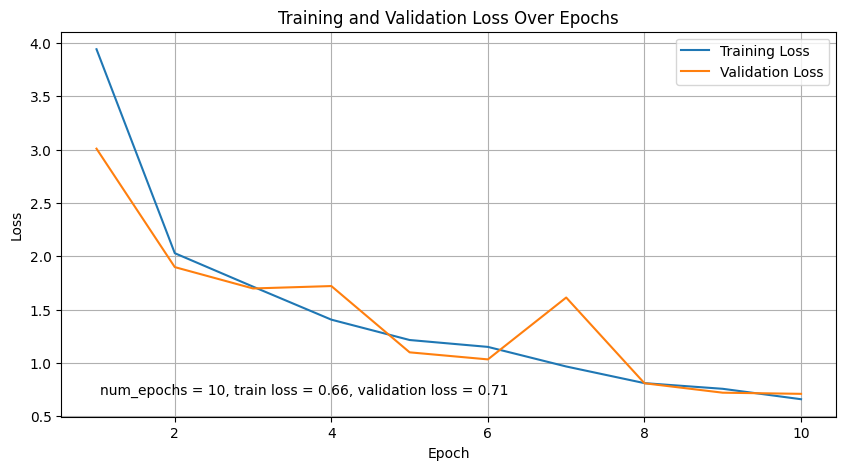

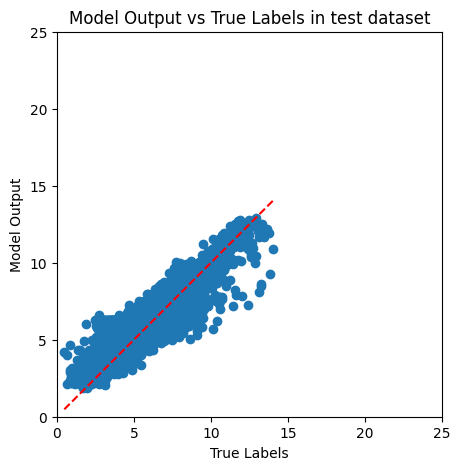

In [6]:
result_path_folder = windscangeo.train_test_model(saved_file_path,
                                            run_name= 'test_run',
                                            model_parameters= model_parameters,
                                            normalization_factors= normalization_factors,
                                            )

### **Function: `inference_full_goes_image()`**

This function runs inference over an entire GOES satellite image using a pre-trained model. The image is automatically downloaded from AWS based on a given datetime, split into 128×128 patches for prediction, and the outputs are reassembled into a full spatial grid of wind speed estimates.

---

### **Inputs**

- **`Datetime`** (`str`):  
  Date and time string (e.g., `"2020-08-21 14:30"`).  
  The inference date must match the date of the training dataset.  
  GOES images are available every 10 minutes — the function will automatically select the closest available image.

- **`scatterometer_data_path`** (`str`):  
  Path to the directory containing `.nc` scatterometer files used during training.  
  This is used to extract the spatial grid template for regridding the model outputs.

- **`result_path_folder`** (`str`):  
  Path to the folder that contains the trained model weights and configuration (i.e., the output of `train_test_model()`).

- **`model_parameters`** (`dict`):  
  Dictionary of model parameters — **must be identical** to the one used during training.  
  Inconsistencies (e.g., using a different architecture or channel configuration) will cause errors or incorrect outputs.

- **`buoy_path`** (`str`):  
  Directory containing `.nc` buoy data files from the **PIRATA** array for external validation.  
  These files can be downloaded from:  
  https://www.brest.ird.fr/pirata/avert_rt.php

- **`normalization_factors`** (`dict`):  
  Mean and standard deviation used during training.  
  These must match exactly; otherwise, inference results may be unreliable or completely incorrect.

- **`goes_aws_url_folder`** (`str`):  
  AWS S3 bucket URL containing the GOES product used during training (e.g., `noaa-goes16/ABI-L2-CMIPF`).  
  The product and channel must match the training data.

- **`goes_channel`** (`str`):  
  GOES channel name used in training (e.g., `"C14"`).  
  The correct channel is needed to extract consistent imagery.

---

### **Description**

This function performs the following steps:

1. **Download GOES Image**  
   - Locates and downloads the GOES image closest to the requested datetime from the specified AWS bucket.

2. **Preprocess Image**  
   - Splits the image into patches of shape `(1, 128, 128)` to match model input dimensions.

3. **Run Inference**  
   - Loads the trained model from `result_path_folder`, applies normalization, and runs inference on all patches.

4. **Reconstruct Output Grid**  
   - Reassembles the predicted wind speeds into a full spatial grid that matches the original GOES image extent.

5. **Validation (Optional)**  
   - If buoy data is provided, performs external validation using colocated buoy observations.

---

> ⚠️ **Important**:  
> For inference to work correctly, all inputs must match the training configuration exactly:
> - Same GOES product and channel  
> - Same model architecture and weights  
> - Same normalization factors  
> - Same image grid (from scatterometer template)

> ✅ This function is useful for generating full-scene wind speed maps from GOES imagery at high temporal resolution.


INFO : Extracting GOES data
INFO : Reading file: s3://noaa-goes16/ABI-L2-CMIPF/2022/001/10/OR_ABI-L2-CMIPF-M6C01_G16_s20220011000207_e20220011009515_c20220011009585.nc
INFO : Extracting images


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1004: RuntimeWarning: Mean of empty slice.
  x_mean = parallel_index[i][j][1].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1005: RuntimeWarning: overflow encountered in scalar subtract
  x_min = x_mean - 63
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1007: RuntimeWarning: Mean of empty slice.
  y_mean = parallel_index[i][j][0].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1008: RuntimeWarning: overflow encountered in scalar subtract
  y_min = y_mean - 63


./results_folder/model_day_test_run/epoch_10.pth
INFO : starting inference


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/run_function.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

INFO : Folder of inference created: ./results_folder/model_day_test_run//inference_2022-01-01_10-00-00/
EVAL : Buoy ['12n23w'] - Inference Wind Speed : 6.551836967468262 - Buoy Wind Speed : 6.0 - Difference : 0.5518369674682617, Percentage Cloud : 0.00885009765625
EVAL : Buoy ['8s30w'] - Inference Wind Speed : 7.520511150360107 - Buoy Wind Speed : 7.070000171661377 - Difference : 0.45051097869873047, Percentage Cloud : 0.0595703125
EVAL : Buoy ['20n38w'] - Inference Wind Speed : 7.2241668701171875 - Buoy Wind Speed : 3.299999952316284 - Difference : 3.9241669178009033, Percentage Cloud : 0.020263671875
EVAL : Buoy ['14s32w'] - Inference Wind Speed : 7.103763103485107 - Buoy Wind Speed : 6.159999847412109 - Difference : 0.943763256072998, Percentage Cloud : 0.8638916015625
EVAL : Buoy ['0n23w'] - Inference Wind Speed : 5.321190357208252 - Buoy Wind Speed : 5.0 - Difference : 0.32119035720825195, Percentage Cloud : 0.24114990234375
EVAL : Buoy ['4n23w'] - Inference Wind Speed : 2.8025553

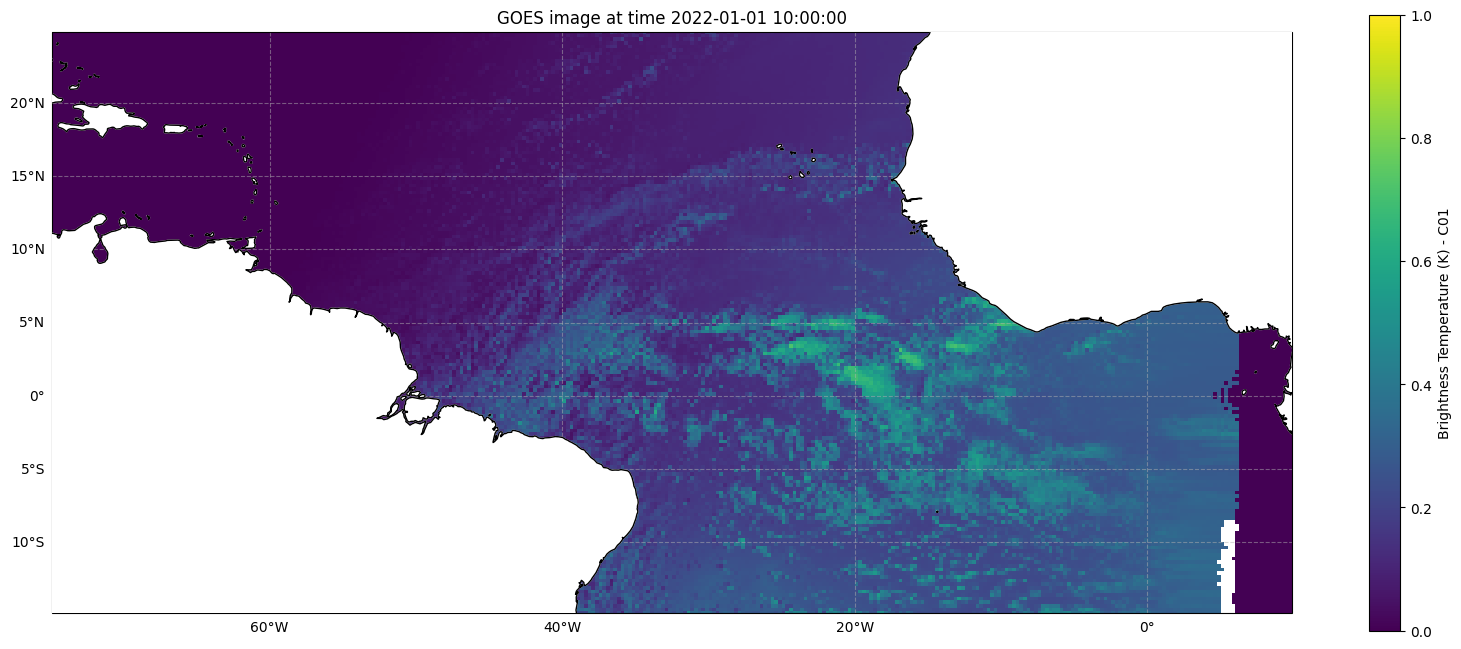

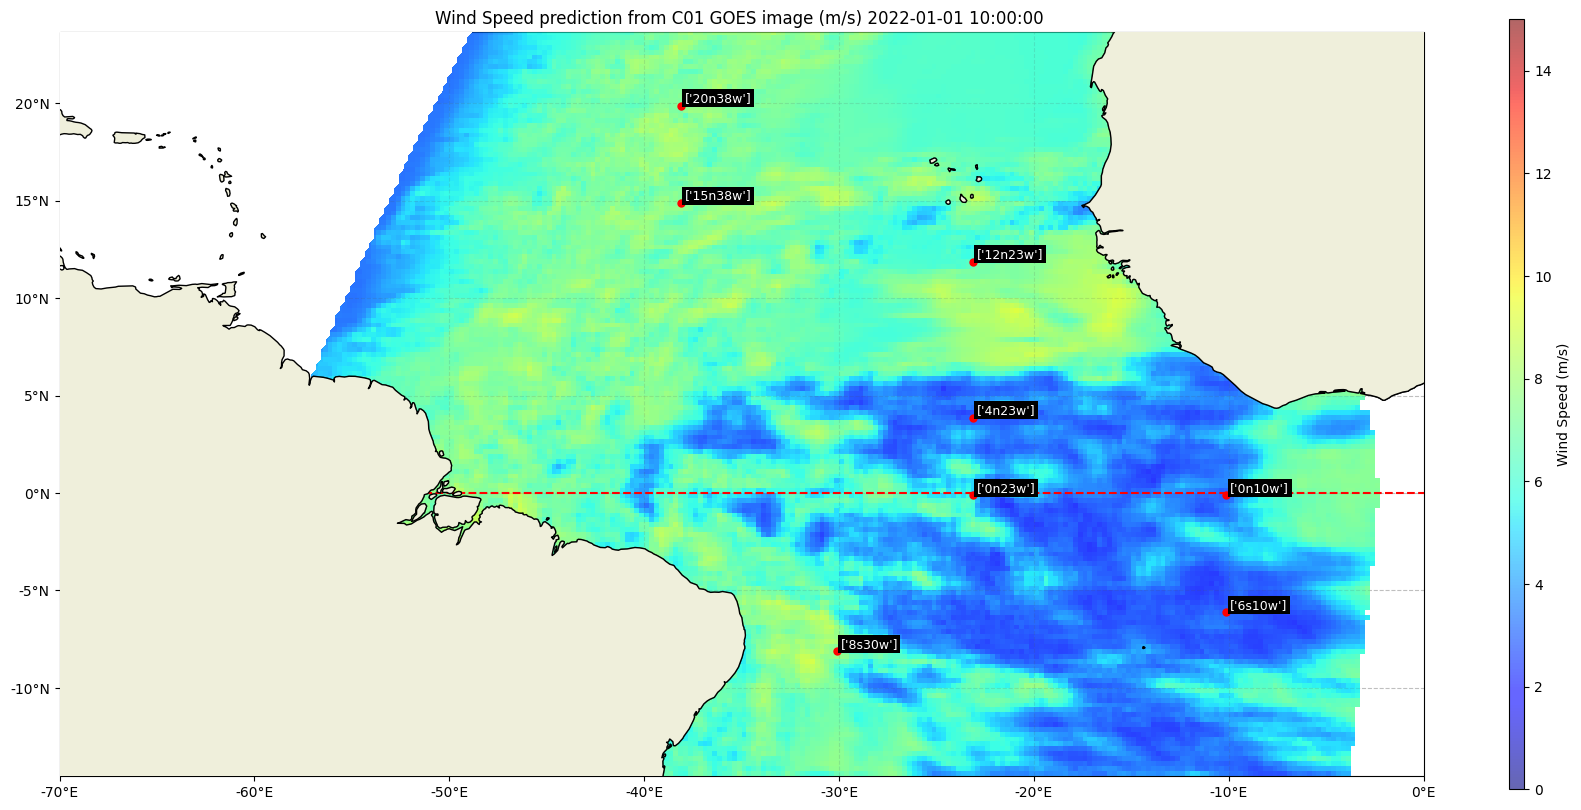

In [11]:
windscangeo.inference_full_goes_image(datetime = '2022-01-01 T10:00:00', # run a loop with different times 
                                    scatterometer_data_path= "../Copernicus_Scatterometer/",
                                    result_path_folder = result_path_folder,
                                    model_parameters = model_parameters,
                                    buoy_path= "../buoy_validation/data/",
                                    normalization_factors = normalization_factors,
                                    goes_aws_url_folder= "noaa-goes16/ABI-L2-CMIPF", # must be the same as used in training
                                    goes_channel= 'C01', # must be the same as used in training
)

A loop can be used to infer a batch of different times. GOES images are taken every 10 minutes. 

In [ ]:
hours = [10,11,12,13,14,15,16,17,18]

for hour in hours:
    specific_time = datetime.datetime(2022, 1, 1, hour, 0, 0) # specify the time you want to run the inference for

    windscangeo.inference_full_goes_image(datetime = specific_time, # run a loop with different times 
                                        scatterometer_data_path= "../Copernicus_Scatterometer/",
                                        result_path_folder = result_path_folder,
                                        model_parameters = model_parameters,
                                        buoy_path= "../buoy_validation/data/",
                                        normalization_factors = normalization_factors,
                                        goes_aws_url_folder= "noaa-goes16/ABI-L2-CMIPF", # must be the same as used in training
                                        goes_channel= 'C01', # must be the same as used in training
    )

INFO : Extracting GOES data
INFO : Reading file: s3://noaa-goes16/ABI-L2-CMIPF/2022/001/10/OR_ABI-L2-CMIPF-M6C01_G16_s20220011000207_e20220011009515_c20220011009585.nc
INFO : Extracting images


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1004: RuntimeWarning: Mean of empty slice.
  x_mean = parallel_index[i][j][1].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1005: RuntimeWarning: overflow encountered in scalar subtract
  x_min = x_mean - 63
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1007: RuntimeWarning: Mean of empty slice.
  y_mean = parallel_index[i][j][0].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1008: RuntimeWarning: overflow encountered in scalar subtract
  y_min = y_mean - 63


./results_folder/model_day_test_run/epoch_10.pth
INFO : starting inference


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/run_function.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

INFO : Folder of inference created: ./results_folder/model_day_test_run//inference_2022-01-01_10-00-00/
EVAL : Buoy ['12n23w'] - Inference Wind Speed : 6.551836967468262 - Buoy Wind Speed : 6.0 - Difference : 0.5518369674682617, Percentage Cloud : 0.00885009765625
EVAL : Buoy ['8s30w'] - Inference Wind Speed : 7.520511150360107 - Buoy Wind Speed : 7.070000171661377 - Difference : 0.45051097869873047, Percentage Cloud : 0.0595703125
EVAL : Buoy ['20n38w'] - Inference Wind Speed : 7.2241668701171875 - Buoy Wind Speed : 3.299999952316284 - Difference : 3.9241669178009033, Percentage Cloud : 0.020263671875
EVAL : Buoy ['14s32w'] - Inference Wind Speed : 7.103763103485107 - Buoy Wind Speed : 6.159999847412109 - Difference : 0.943763256072998, Percentage Cloud : 0.8638916015625
EVAL : Buoy ['0n23w'] - Inference Wind Speed : 5.321190357208252 - Buoy Wind Speed : 5.0 - Difference : 0.32119035720825195, Percentage Cloud : 0.24114990234375
EVAL : Buoy ['4n23w'] - Inference Wind Speed : 2.8025553

/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1004: RuntimeWarning: Mean of empty slice.
  x_mean = parallel_index[i][j][1].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1005: RuntimeWarning: overflow encountered in scalar subtract
  x_min = x_mean - 63
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1007: RuntimeWarning: Mean of empty slice.
  y_mean = parallel_index[i][j][0].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1008: RuntimeWarning: overflow encountered in scalar subtract
  y_min = y_mean - 63


./results_folder/model_day_test_run/epoch_10.pth
INFO : starting inference


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/run_function.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

INFO : Folder of inference created: ./results_folder/model_day_test_run//inference_2022-01-01_11-00-00/
EVAL : Buoy ['12n23w'] - Inference Wind Speed : 6.509059429168701 - Buoy Wind Speed : 5.800000190734863 - Difference : 0.7090592384338379, Percentage Cloud : 0.00201416015625
EVAL : Buoy ['8s30w'] - Inference Wind Speed : 6.41375207901001 - Buoy Wind Speed : 7.079999923706055 - Difference : -0.6662478446960449, Percentage Cloud : 0.02392578125
EVAL : Buoy ['20n38w'] - Inference Wind Speed : 8.33681869506836 - Buoy Wind Speed : 3.5999999046325684 - Difference : 4.736818790435791, Percentage Cloud : 0.030029296875
EVAL : Buoy ['14s32w'] - Inference Wind Speed : 6.146809101104736 - Buoy Wind Speed : 6.699999809265137 - Difference : -0.5531907081604004, Percentage Cloud : 0.49310302734375
EVAL : Buoy ['0n23w'] - Inference Wind Speed : 4.04539155960083 - Buoy Wind Speed : 6.099999904632568 - Difference : -2.0546083450317383, Percentage Cloud : 0.15093994140625
EVAL : Buoy ['4n23w'] - Infe

/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1004: RuntimeWarning: Mean of empty slice.
  x_mean = parallel_index[i][j][1].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1005: RuntimeWarning: overflow encountered in scalar subtract
  x_min = x_mean - 63
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1007: RuntimeWarning: Mean of empty slice.
  y_mean = parallel_index[i][j][0].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1008: RuntimeWarning: overflow encountered in scalar subtract
  y_min = y_mean - 63


./results_folder/model_day_test_run/epoch_10.pth
INFO : starting inference


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/run_function.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

INFO : Folder of inference created: ./results_folder/model_day_test_run//inference_2022-01-01_12-00-00/
EVAL : Buoy ['12n23w'] - Inference Wind Speed : 6.115354061126709 - Buoy Wind Speed : 5.800000190734863 - Difference : 0.3153538703918457, Percentage Cloud : 0.00390625
EVAL : Buoy ['8s30w'] - Inference Wind Speed : 6.461004257202148 - Buoy Wind Speed : 7.179999828338623 - Difference : -0.7189955711364746, Percentage Cloud : 0.0054931640625
EVAL : Buoy ['20n38w'] - Inference Wind Speed : 8.358855247497559 - Buoy Wind Speed : 3.0999999046325684 - Difference : 5.25885534286499, Percentage Cloud : 0.0838623046875
EVAL : Buoy ['14s32w'] - Inference Wind Speed : 6.686221122741699 - Buoy Wind Speed : 6.869999885559082 - Difference : -0.1837787628173828, Percentage Cloud : 0.00830078125
EVAL : Buoy ['0n23w'] - Inference Wind Speed : 5.3761210441589355 - Buoy Wind Speed : 5.300000190734863 - Difference : 0.07612085342407227, Percentage Cloud : 0.05029296875
EVAL : Buoy ['4n23w'] - Inference 

/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1004: RuntimeWarning: Mean of empty slice.
  x_mean = parallel_index[i][j][1].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1005: RuntimeWarning: overflow encountered in scalar subtract
  x_min = x_mean - 63
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1007: RuntimeWarning: Mean of empty slice.
  y_mean = parallel_index[i][j][0].mean().astype(int)
/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/func.py:1008: RuntimeWarning: overflow encountered in scalar subtract
  y_min = y_mean - 63


./results_folder/model_day_test_run/epoch_10.pth
INFO : starting inference


/home/yongxing/Documents/DoldrumsAI/3.0.0 showcase/windscangeo/run_function.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

INFO : Folder of inference created: ./results_folder/model_day_test_run//inference_2022-01-01_13-00-00/
EVAL : Buoy ['12n23w'] - Inference Wind Speed : 6.023229122161865 - Buoy Wind Speed : 6.699999809265137 - Difference : -0.6767706871032715, Percentage Cloud : 0.98443603515625
EVAL : Buoy ['8s30w'] - Inference Wind Speed : 6.229635238647461 - Buoy Wind Speed : 7.650000095367432 - Difference : -1.4203648567199707, Percentage Cloud : 0.0054931640625
EVAL : Buoy ['20n38w'] - Inference Wind Speed : 6.643625736236572 - Buoy Wind Speed : 4.300000190734863 - Difference : 2.343625545501709, Percentage Cloud : 0.0596923828125
EVAL : Buoy ['14s32w'] - Inference Wind Speed : 6.460587024688721 - Buoy Wind Speed : 6.400000095367432 - Difference : 0.06058692932128906, Percentage Cloud : 0.0009765625
EVAL : Buoy ['0n23w'] - Inference Wind Speed : 5.04739236831665 - Buoy Wind Speed : 5.300000190734863 - Difference : -0.2526078224182129, Percentage Cloud : 0.04766845703125
EVAL : Buoy ['4n23w'] - Inf